In [1]:
import os
import shutil
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage import io
from scipy.optimize import curve_fit
from scipy.signal import savgol_filter

# local
from utils import *
sys.path.append("../imaging-utils")
from image_arrays import *

### Activate interactive plotting
By default, inline plots are static. Here we specify one of two options (comment out the undesired command) that will open plots with GUI controls for us.
- **qt ->** figures opened in windows outside the notebook
- **notebook ->** figures within notebook underneath generating cell.

In [2]:
# %matplotlib qt 
%matplotlib notebook

In [3]:
base_path = "/mnt/Data/prerna_velocity/"
data_path = os.path.join(base_path, "2021_06_16_processed_4x4")
stim_labels = ["moving_spot", "snake"]

In [4]:
vel_data = {
    stim: {
        depth: {
            int(vel): np.stack(
                [
                    io.imread(os.path.join(data_path, stim, depth, vel, f))
                    for f in os.listdir(os.path.join(data_path, stim, depth, vel))
                    if (f.endswith(".tiff") or f.endswith(".tif"))
                ],
                axis=0
            )
            for vel in os.listdir(os.path.join(data_path, stim, depth))
            if (os.path.isdir(os.path.join(data_path, stim, depth, vel)) and vel.isnumeric())        
        }
        for depth in ["DD", "PD"]
    } 
    for stim in stim_labels
}

vel_df = {
    stim: {
        d: {
            v: ((trials - np.mean(trials[:, 50:150], axis=1, keepdims=True)) 
                / (np.mean(trials[:, 50:150], axis=1, keepdims=True) + 0.00001))
            for v, trials in vels.items()
        }
        for d, vels in depths.items()
    } 
    for stim, depths in vel_data.items()
}

stacked_vels = {
    stim: {
        d: np.stack([ts for ts in vels.values()], axis=1)
        for d, vels in depths.items()
    }
    for stim, depths in vel_df.items()
}

n_trials, n_frames, y_sz, x_sz = vel_data[stim_labels[0]]["DD"][300].shape
n_vels = len(vel_data[stim_labels[0]]["DD"])
dt = 1 / 58.25
recs_xaxis = np.arange(n_frames) * dt
velocities = np.array(list(sorted(vel_data[stim_labels[0]]["DD"].keys())))
print("velocity stack shape:", vel_data[stim_labels[0]]["DD"][300].shape)
print("velocity df shape:", vel_df[stim_labels[0]]["DD"][300].shape)
print("stacked vel df shape", stacked_vels[stim_labels[0]]["DD"].shape)

velocity stack shape: (2, 450, 64, 64)
velocity df shape: (2, 450, 64, 64)
stacked vel df shape (2, 8, 450, 64, 64)


### Dynamic ROI plot of a scan (of particular `depth`) during stimulation by spot moving at `vel` 

<IPython.core.display.Javascript object>


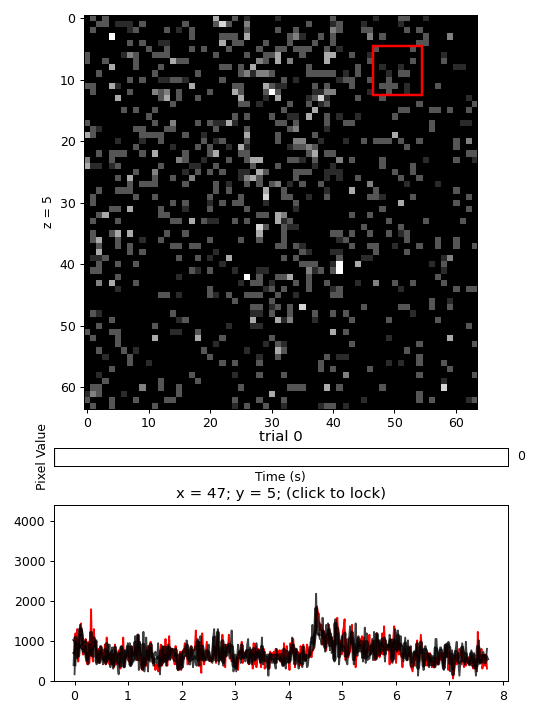

In [16]:
vel = 1000
stim = "snake"
depth = "PD"

stack_plot = StackExplorer(
    vel_data[stim][depth][vel],
    zaxis=recs_xaxis,
    delta=5,
    roi_sz=(8, 8),
    vmin=0,
    figsize=(6, 8)
)
stack_plot.ax[1].set_xlabel("Time (s)")
stack_plot.ax[1].set_ylabel("Pixel Value")
stack_plot.fig.show()

### Grid ROI placement
Take `grid_w` by `grid_h` beams from the scan field

In [6]:
grid_w = 8
grid_h = 8
edge_cut = 0

def aligned_avg(avg_recs, bsln_start=60, bsln_end=150, step=1, offset=-0.1, max_shift=20):
    rise_idxs = np.array([
            find_rise_bsln(r, bsln_start=bsln_start, bsln_end=bsln_end, step=step)
            for r in avg_recs
        ])
    shifts = np.clip(rise_idxs - np.min(rise_idxs), 0, max_shift)
    trim = np.max(shifts)
    aligned = np.mean(
        [r[s:(-trim + s) if s != trim else None] for r, s in zip(avg_recs, shifts)],
        axis=0
    )
    return aligned

min_qi = 0.
grid_recs, avg_grid_recs, aligned_grid_avg, grid_locs, all_qis, accepted_qis = [
    {} for _ in range(6)
]
for stim, depths in vel_df.items():
    grid_recs[stim], avg_grid_recs[stim], grid_locs[stim] = {}, {}, {}
    aligned_grid_avg[stim], all_qis[stim], accepted_qis[stim] = {}, {}, {}
    for depth, vels in depths.items():
        grid_recs[stim][depth], avg_grid_recs[stim][depth], grid_locs[stim][depth] = {}, {}, {}
        aligned_grid_avg[stim][depth], all_qis[stim][depth], accepted_qis[stim][depth] = {}, {}, {}
        for v, stack in vels.items():
            recs, locs, acc_qis, qis = [], [], [], []
            for y0 in range(0, y_sz, grid_h):
                for x0 in range(edge_cut, x_sz - edge_cut, grid_w):
                    beams = np.mean(stack[:, :, y0:y0 + grid_h, x0:x0 + grid_w], axis=(2, 3))
                    qi = quality_index(beams[:, 60:])
                    qis.append(qi)
                    if qi > min_qi and np.max(np.var(beams)) < 1000:
                        acc_qis.append(qi)
                        recs.append(beams)
                        locs.append([x0, y0])        
            grid_recs[stim][depth][v] = np.stack(recs, axis=1)
            avg_grid_recs[stim][depth][v] = np.mean(grid_recs[stim][depth][v], axis=0)
            grid_locs[stim][depth][v] = np.stack(locs, axis=0)
            aligned_grid_avg[stim][depth][v] = aligned_avg(avg_grid_recs[stim][depth][v])
            accepted_qis[stim][depth][v] = np.array(acc_qis)
            all_qis[stim][depth][v] = np.array(qis)

# print("number of grid ROIs accepted:", grid_recs.shape[1])

### Similar, but calculating QI on a concatenation of all velocities (for each trial), so is just one QI for each grid position. This way each kept grid cell is present for each velocity, and peak-area ratios can be calculated for each cell without missing data.

In [7]:
min_qi = 0.5
stk_grid_recs, stk_avg_grid_recs, stk_grid_locs, stk_all_qis, stk_accepted_qis = [
    {} for _ in range(5)
]
for stim, depths in stacked_vels.items():
    stk_grid_recs[stim], stk_avg_grid_recs[stim], stk_grid_locs[stim] = {}, {}, {}
    stk_all_qis[stim], stk_accepted_qis[stim] = {}, {}
    for depth, vels in depths.items():
        recs, locs, acc_qis, qis = [], [], [], []
        for y0 in range(0, y_sz, grid_h):
            for x0 in range(edge_cut, x_sz - edge_cut, grid_w):
                beams = np.mean(vels[:, :, :, y0:y0 + grid_h, x0:x0 + grid_w], axis=(3, 4))
                qi = quality_index(beams.reshape(n_trials, -1))
                qis.append(qi)
                if qi > min_qi:
                    acc_qis.append(qi)
                    recs.append(beams)
                    locs.append([x0, y0])        
        stk_grid_recs[stim][depth] = np.stack(recs, axis=1)
        stk_avg_grid_recs[stim][depth] = np.mean(stk_grid_recs[stim][depth], axis=0)
        stk_grid_locs[stim][depth] = np.stack(locs, axis=0)
        stk_accepted_qis[stim][depth] = np.array(acc_qis)
        stk_all_qis[stim][depth] = np.array(qis)

<IPython.core.display.Javascript object>


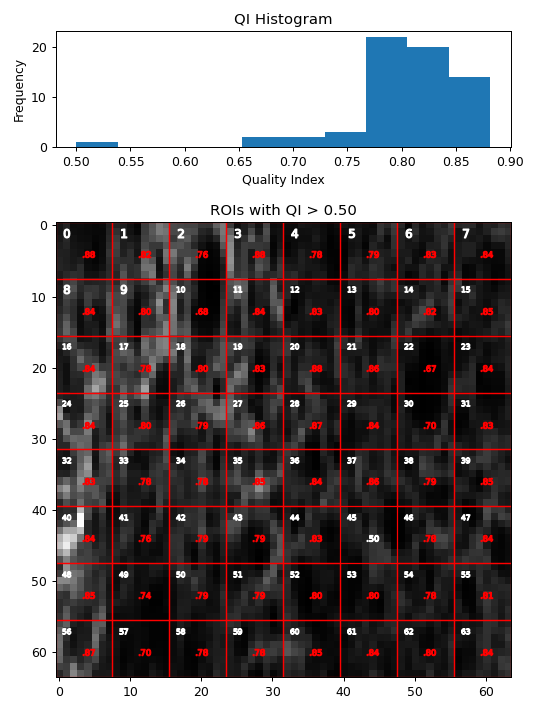

In [8]:
stim = "snake"
depth = "DD"
vel = None
if vel is None:
    quality_idxs = stk_all_qis[stim][depth]
    grid_locations = stk_grid_locs[stim][depth]
else:
    quality_idxs = all_qis[stim][depth][vel]
    grid_locations = grid_locs[stim][depth][vel]

mean_stack_proj = np.mean(
    np.stack([v for v in vel_data[stim][depth].values()], axis=0), axis=(0, 1, 2))
    
half_w = grid_w / 2
half_h = grid_h / 2
grid_fig, grid_ax = plt.subplots(
    2, 
    gridspec_kw={"height_ratios": [.2, .8]}, 
    figsize=(6, 8)
)

grid_ax[0].hist(quality_idxs)
grid_ax[0].set_title("QI Histogram")
grid_ax[0].set_xlabel("Quality Index")
grid_ax[0].set_ylabel("Frequency")

grid_ax[1].imshow(mean_stack_proj, cmap="gray")
grid_ax[1].set_title("ROIs with QI > %.2f" % min_qi)

for (x, y) in grid_locations:
    grid_ax[1].add_patch(
        Rectangle(
            (x - .5, y - .5),  # grid offset
            grid_w, 
            grid_h, 
            fill=False,
            color="red",
            linewidth=1,
            linestyle="-"
        )
    )

i = 0
for y0 in range(0, y_sz, grid_h):
    for x0 in range(edge_cut, x_sz - edge_cut, grid_w):
        grid_ax[1].scatter(
            x0 + half_w,
            y0 + half_h, 
            marker="$%s$" % ("%.2f" % quality_idxs[i]).lstrip("0"), 
            s=100,
            c="red" if quality_idxs[i] > min_qi else "1",
        )
        grid_ax[1].scatter(
            x0 + half_w / 4,
            y0 + half_h / 4, 
            marker="$%i$" % i, 
            s=50,
            c="1",
        )
        i += 1
        
grid_fig.tight_layout()

### Use PeakExplorer to browse through ROIs (scroll wheel) of from the average scans taken from `depth` during `vel` stimulation  

<IPython.core.display.Javascript object>


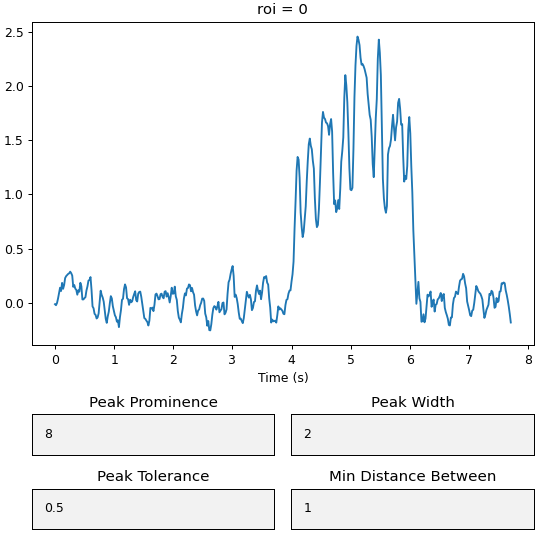

In [9]:
stim = "snake"
depth = "PD"
vel = 100


filtered = np.stack(
    [savgol_filter(roi, 11, 3) for roi in avg_grid_recs[stim][depth][vel]], 
    axis=0
)

peak_explorer = PeakExplorer(
    recs_xaxis, 
#     grid_recs[depth][vel][0],
#     avg_grid_recs[depth][vel],
    filtered,
    prominence=8,
    width=2,
    tolerance=.5,
    distance=1
)

### Cut out the response portion and calculate sust/trans index for each ROI


mean pd = 0.06668242402163238
mean dd = 0.050624390754647315


<IPython.core.display.Javascript object>


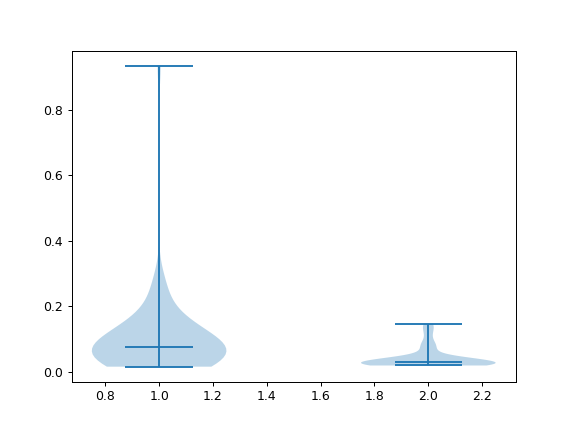

{'bodies': [<matplotlib.collections.PolyCollection at 0x7fe029110ee0>,
 'cmaxes': <matplotlib.collections.LineCollection at 0x7fe029160cd0>,
 'cmins': <matplotlib.collections.LineCollection at 0x7fe029122700>,
 'cbars': <matplotlib.collections.LineCollection at 0x7fe029122a30>,
 'cmedians': <matplotlib.collections.LineCollection at 0x7fe029122d60>}

In [10]:
extra_t = 0.1

def peak_area_ratio(r, bsln_start=60, bsln_end=150, step=1):
    start_idx = find_rise_bsln(r, bsln_start=bsln_start, bsln_end=bsln_end, step=step)
    end_idx = find_bsln_return(r, bsln_start=bsln_start, bsln_end=bsln_end, step=step)
    return np.max(r[start_idx:end_idx]) / np.sum(r[start_idx:end_idx])

peak_area_ratios = {
    stim: {
        depth: {
            vel: np.stack([peak_area_ratio(r) for r in recs], axis=0)
            for vel, recs in vels.items() 
        }
        for depth, vels in depths.items()
    }
    for stim, depths in avg_grid_recs.items()
}

print()
# stk_peak_area_ratios = {
#     stim: {
#         depth: {
#             np.stack([peak_area_ratio(r) for r in recs], axis=0)
#         }
#         for depth, vels in depths.items()
#     }
#     for stim, depths in avg_grid_recs.items()
# }

print("mean pd =", np.mean(peak_area_ratios["snake"]["PD"][500]))
print("mean dd =", np.mean(peak_area_ratios["snake"]["DD"][500]))

# test_set = {
#     "PD": peak_area_ratios["moving_spot"]["PD"][300],
#     "DD": peak_area_ratios["moving_spot"]["DD"][300]
# }
test_set = [
    peak_area_ratios["snake"]["PD"][100],
    peak_area_ratios["snake"]["DD"][100]
]
ff, aa = plt.subplots(1)
aa.violinplot(test_set, showmedians=True)

### Comparison between ROIs (or aligned averages) of DD and PD depths for each velocity 

<IPython.core.display.Javascript object>


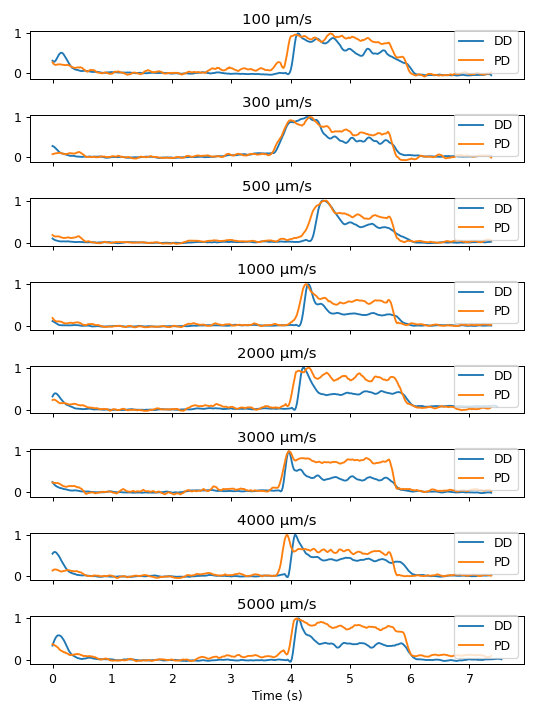

In [11]:
stim = "snake"
grid_idxs = {"DD": 5, "PD": 5}
# grid_idxs = {"DD": 0, "PD": 0}
use_aligned = True

norm = True
depth_comp_fig, depth_comp_ax = plt.subplots(len(velocities), sharex=True, figsize=(6, 8))
for ax, vel in zip(depth_comp_ax, velocities):
#     if vel == 3000:
#         continue
    for depth in vel_df[stim].keys():
        if use_aligned:
            y = savgol_filter(aligned_grid_avg[stim][depth][vel], 11, 3)
        else:
            y = savgol_filter(avg_grid_recs[stim][depth][vel][grid_idxs[depth]], 11, 3)
#         y = avg_grid_recs[stim][depth][vel][3]
#         y = savgol_filter(grid_recs[stim][depth][vel][1, 2], 21, 3)
        x = np.arange(len(y)) * dt
        if norm:
            y /= y.max()
        ax.plot(x, y, label=depth)
        ax.set_title("%i μm/s" % vel)
        ax.legend()
#         ax.set_xlim(4, 5.7)

depth_comp_ax[-1].set_xlabel("Time (s)")
depth_comp_fig.tight_layout()